# Factory dataset

In [224]:
import iplantuml

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [225]:
rng = np.random.RandomState(42)

3 type of competitive events:
- Initial assembly failure $e_1$
- Operation failure $e_2$
- Usure failure $e_3$

Features that interact with the hazards of the events:
- Operator training (none, hands-on, formal): $e_2$.
- Machine model (different assembly quality, UX and material) that create non-linear interaction with operators skills: $e_1, e_2, e_3$.
- Usage rate of the machine: $e_1, e_2, e_3$ (linear impact).

## Operators and machines properties

### Operator training

Across the factory, 1/3 of operators have little to no experience, another 1/3 have prior hands-on training and the last 1/3 has had a formal training on all equipments. We distinguish their skills as:

In [667]:
N = 10_000
t_init = 21
t_fatigue = 130
total_period = 2 * 365

In [393]:
op_skills = [.5, .8, 1]

df = pd.DataFrame(
    dict(
        operator_skills=rng.choice(op_skills, size=N)
    )
)
df.head()

,operator_skills
0,1.0
1,0.5
2,1.0
3,0.5
4,1.0


### Machine model and hidden variables

We then represent the hidden variables that are contains in a machine instance:

Writing output for /Users/vincentmaladiere/INRIA/survival-analysis-benchmark/notebooks/2bdbc9f2-605f-49a3-b80b-17e39e513e24.uml to 2bdbc9f2-605f-49a3-b80b-17e39e513e24.svg


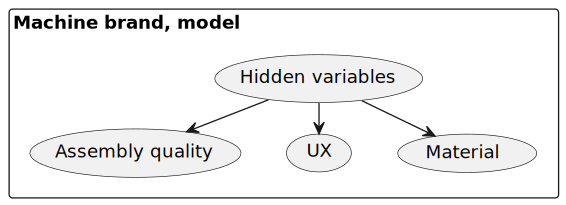

In [425]:
%%plantuml

skinparam ranksep 20
skinparam dpi 125
skinparam packageTitleAlignment left

rectangle "Machine brand, model" {
  (Hidden variables)
  (Assembly quality)
  (UX)
  (Material)
}

(Hidden variables)-down->(Assembly quality)
(Hidden variables)-down->(UX)
(Hidden variables)-down->(Material)

### Assembly quality

Let's imagine that the assembly quality depends on the supplier brand. There are two brands on the market, B1 and B2. B2 is cheaper but has an assembly quality that is less reliable:

$Q(B_1) \sim \mathcal{N}(0.90, 0.025) \\ Q(B_2) \sim \mathcal{N}(0.85, 0.050)$

In [395]:
from scipy.stats import norm

def get_norm_x_y(mu, sigma):
    x = np.linspace(
        norm.ppf(0.01, loc=mu, scale=sigma),
        norm.ppf(0.99, loc=mu, scale=sigma),
    )
    y = norm.pdf(x, loc=mu, scale=sigma)
    return x, y

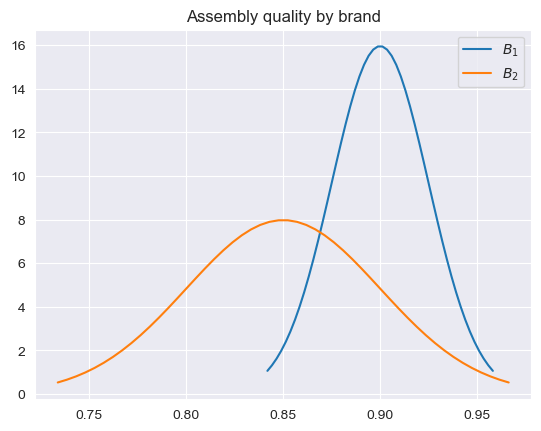

In [396]:
q_mu_1, q_sigma_1 = .90, 0.025
q_mu_2, q_sigma_2 = .85, 0.050

x_1, y_1 = get_norm_x_y(q_mu_1, q_sigma_1)
x_2, y_2 = get_norm_x_y(q_mu_2, q_sigma_2)

fig, ax = plt.subplots()
ax.plot(x_1, y_1, label="$B_1$")
ax.plot(x_2, y_2, label="$B_2$")
ax.set_title("Assembly quality by brand")
plt.legend();

In [397]:
df["brand"] = pd.Series(["B1"] * (N//2) + ["B2"] * (N//2))

assembly_quality = np.hstack([
    norm.rvs(loc=q_mu_1, scale=q_sigma_1, size=N//2, random_state=rng),
    norm.rvs(loc=q_mu_2, scale=q_sigma_2, size=N//2, random_state=rng),
])
df["assembly_quality"] = assembly_quality

df.head()

,operator_skills,brand,assembly_quality
0,1.0,B1,0.889414
1,0.5,B1,0.894534
2,1.0,B1,0.906668
3,0.5,B1,0.885838
4,1.0,B1,0.907561


### UX

Both brands produce 5 models with similar UX, depending on the year there were designed. Older machines are often less intuitive and trickier to use, so we imagine a UX that is increasing as time goes by.

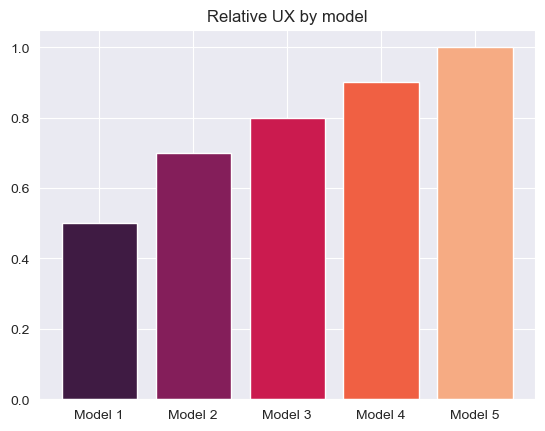

In [398]:
ux_options = [.5, .7, .8, .9, 1]
labels = [f"Model {idx}" for idx in range(1, len(ux_options)+1)]
ux_models = dict(zip(ux_options, labels))

fig, ax = plt.subplots()
palette = sns.color_palette("rocket", n_colors=5)
plt.bar(labels, height=ux_options, color=palette);
plt.title("Relative UX by model");

In [399]:
ux = rng.choice(ux_options, size=N)
df["model_id"] = pd.Series(ux).map(ux_models)
df["ux"] = ux

df.head()

,operator_skills,brand,assembly_quality,model_id,ux
0,1.0,B1,0.889414,Model 2,0.7
1,0.5,B1,0.894534,Model 5,1.0
2,1.0,B1,0.906668,Model 1,0.5
3,0.5,B1,0.885838,Model 4,0.9
4,1.0,B1,0.907561,Model 5,1.0


### Material quality

Both brands also use similar alloy and plastic, however newer machines are often built with cheaper components, so that the more recent the model, the lower the overall material quality. 

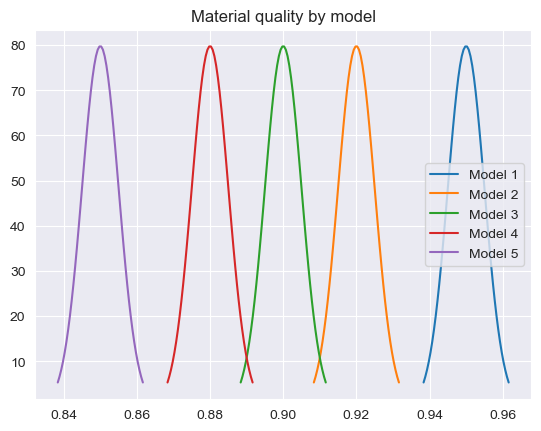

In [400]:
fig, ax = plt.subplots()

material_quality = [
    (.95, .005),
    (.92, .005),
    (.90, .005),
    (.88, .005),
    (.85, .005),
]
material_models = dict(zip(labels, material_quality))

for idx, (mu, sigma) in enumerate(material_quality, 1):
    x, y = get_norm_x_y(mu, sigma)
    ax.plot(x, y, label=f"Model {idx}")
    ax.set_title("Material quality by model")
    plt.legend();

In [401]:
materials_stats = df["model_id"].map(models_material)
df["materials"] = np.hstack([
    norm.rvs(loc=m_mu, scale=m_sigma, random_state=rng, size=1)
    for m_mu, m_sigma in materials_stats
])
df.head()

,operator_skills,brand,assembly_quality,model_id,ux,materials
0,1.0,B1,0.889414,Model 2,0.7,0.920184
1,0.5,B1,0.894534,Model 5,1.0,0.844707
2,1.0,B1,0.906668,Model 1,0.5,0.952254
3,0.5,B1,0.885838,Model 4,0.9,0.878855
4,1.0,B1,0.907561,Model 5,1.0,0.844338


### Usage rate

Finally, depending on their position in the production line but independently to their model, each machine has a specific usage rate, that will linearly impact each of the 3 hazards. We can imagine a bimodal distribution of the usage, with some machines being used almost continuously while some others are used in batches.

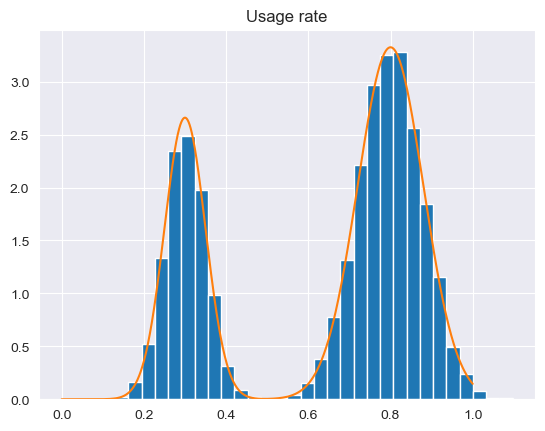

In [402]:
u_mu_1, u_sigma_1 = .3, .05
u_mu_2, u_sigma_2 = .8, .08
usage_params = [(u_mu_1, u_sigma_1 ), (u_mu_2, u_sigma_2)]

usage_weights = np.array([.5, 1])
usage_weights /= usage_weights.sum()
usage_mixture_idxs = rng.choice(len(usage_weights), size=N, p=usage_weights)

y = np.hstack([
    norm.rvs(*usage_params[idx], random_state=rng)
    for idx in usage_mixture_idxs
])

fig, ax = plt.subplots()
ax.hist(y, density=True, bins=30)

x = np.linspace(0, 1, N)
y_pdf = np.zeros(x.shape[0])
for (u_mu, u_sigma), w in zip(usage_params, usage_weights):
    y_pdf += norm.pdf(x, loc=u_mu, scale=u_sigma) * w

ax.plot(x, y_pdf)
ax.set_title("Usage rate");

In [403]:
df["usage_rate"] = y
df.head()

,operator_skills,brand,assembly_quality,model_id,ux,materials,usage_rate
0,1.0,B1,0.889414,Model 2,0.7,0.920184,0.309469
1,0.5,B1,0.894534,Model 5,1.0,0.844707,0.869121
2,1.0,B1,0.906668,Model 1,0.5,0.952254,0.832492
3,0.5,B1,0.885838,Model 4,0.9,0.878855,0.309969
4,1.0,B1,0.907561,Model 5,1.0,0.844338,0.698832


## Assembly hazard $e_1$

We model the h1 hazard with the Weibull distribution:

$f(x, \lambda, k)=\begin{cases}\frac{k}{\lambda}(\frac{x}{\lambda})^{k-1}e^{-(x/\lambda)^k} & \mathrm{if}\; x \geq 0 \\ 0 & \mathrm{o.w.}\end{cases}$

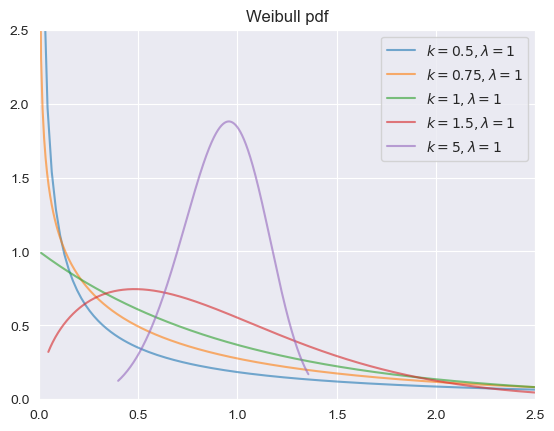

In [404]:
from scipy.stats import weibull_min

fig, ax = plt.subplots()
for k in [.5, .75, 1, 1.5, 5]:
    x = np.linspace(
        weibull_min.ppf(0.01, k),
        weibull_min.ppf(0.99, k),
        1000,
    )
    y = weibull_min.pdf(x, k, loc=0, scale=1)
    ax.plot(x, y, alpha=0.6, label=f"$k={k}, \lambda=1$");
ax.set(
    title="Weibull pdf",
    xlim=[0, 2.5],
    ylim=[0, 2.5],
);
plt.legend();

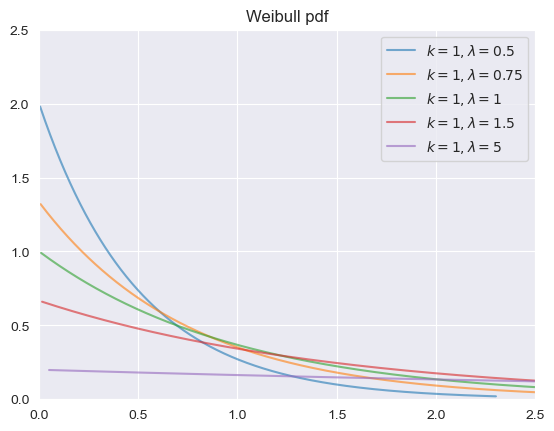

In [405]:
from scipy.stats import weibull_min

k = 1
fig, ax = plt.subplots()
for l in [.5, 0.75, 1, 1.5, 5]:
    t = np.linspace(
        weibull_min.ppf(0.01, k, scale=l),
        weibull_min.ppf(0.99, k, scale=l),
        1000,
    )
    y = weibull_min.pdf(t, k, loc=0, scale=l)
    ax.plot(t, y, alpha=0.6, label=f"$k={k}, \lambda={l}$");
ax.set(
    title="Weibull pdf",
    xlim=[0, 2.5],
    ylim=[0, 2.5],
);
plt.legend();

So we want a fix shape parameter $k$ and a scale $\lambda$ that varies according to our couple (machine, operator).

Therefore, $\lambda \propto \mathrm{assembly\; quality} \times (1 - \mathrm{usage\; rate})$

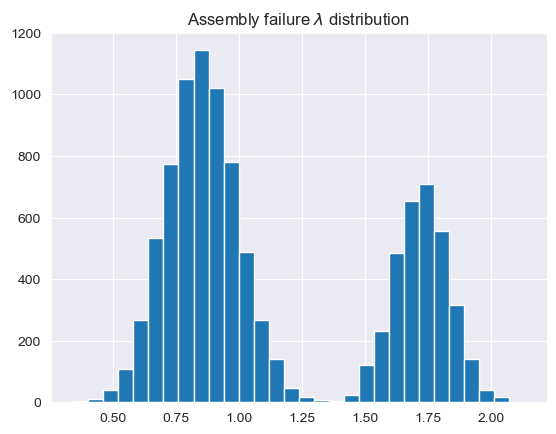

In [406]:
df["e_1_lambda"] = 2 * df["assembly_quality"] * (1-df["usage_rate"]) + .5
plt.hist(df["e_1_lambda"], bins=30);
plt.title("Assembly failure $\lambda$ distribution");

In [407]:
df.head()

,operator_skills,brand,assembly_quality,model_id,ux,materials,usage_rate,e_1_lambda
0,1.0,B1,0.889414,Model 2,0.7,0.920184,0.309469,1.728335
1,0.5,B1,0.894534,Model 5,1.0,0.844707,0.869121,0.734152
2,1.0,B1,0.906668,Model 1,0.5,0.952254,0.832492,0.803749
3,0.5,B1,0.885838,Model 4,0.9,0.878855,0.309969,1.722511
4,1.0,B1,0.907561,Model 5,1.0,0.844338,0.698832,1.046656


Let's convert the x axis from weeks to days, and scale the y by 100.

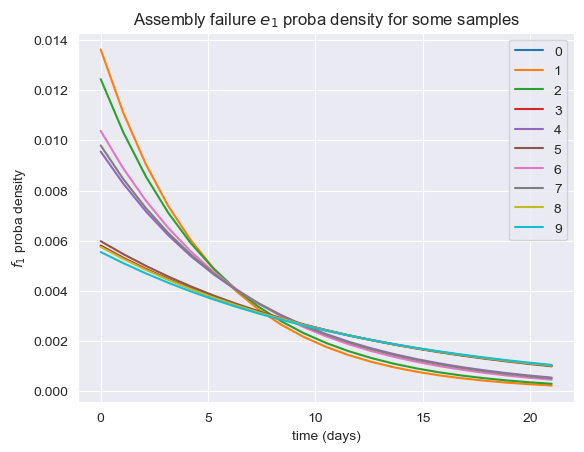

In [489]:
t = np.linspace(0, 3, 21)  # 3 weeks
e_1 = [weibull_min.pdf(t, 1, loc=0, scale=l) / 100 for l in df["e_1_lambda"].values]

fig, ax = plt.subplots()
for idx, e_1_ in enumerate(e_1[:10]):
    ax.plot(t * 7, e_1_, label=idx)  # from weeks to days
ax.set(
    title="Assembly failure $e_1$ proba density for some samples",
    xlabel="time (days)",
    ylabel="$f_1$ proba density",
)
plt.legend();

## Operation failure $e_2$

We consider the operation hazard to be constant.

Therefore $e_2 \propto (\frac{1}{\mathrm{operator\; training}})\times \frac{1}{\mathrm{UX}} \times \mathrm{usage\; rate}$.

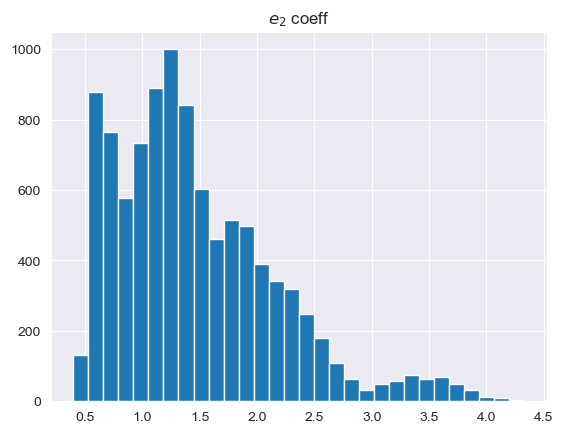

In [482]:
df["e_2_coeff"] = 1/df["operator_skills"] * 1/df["ux"] * df["usage_rate"] + .25
plt.hist(df["e_2_coeff"], bins=30);
plt.title("$e_2$ coeff");

The baseline is one failure every 3 years, which we multiply be the $e_2$ coeff.

In [479]:
e_2_base = 1 / (365 * 3)
e_2_base

0.0009132420091324201

In [480]:
e_2 = e_2_base * df["e_2_coeff"]
e_2

0       0.000632
1       0.001816
2       0.001749
3       0.000857
4       0.000867
          ...   
9995    0.000612
9996    0.000948
9997    0.001086
9998    0.001311
9999    0.001520
Name: e_2_coeff, Length: 10000, dtype: float64

## Usage failure $e_3$

Lastly, usage failure start to increase from some $t > t_{fatigue}$, and then plateau at a high probability regime, in a logistic way.

Here, $e_3 \propto \mathrm{materials} \times \mathrm{usage\; rate}$

In [441]:
def logistic(x, w):
    return 1 / (1 + np.exp(-x * w))

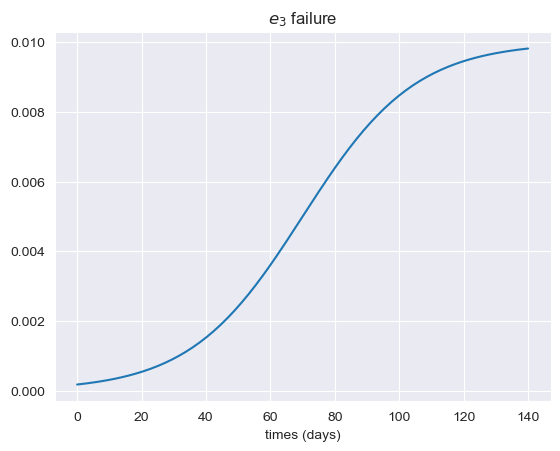

In [596]:
t = np.linspace(-10, 10, t_fatigue)
y = logistic(t, w=0.4)
plt.plot((t + 10) * 7, y / 100);
plt.title("$e_3$ failure")
plt.xlabel("times (days)");

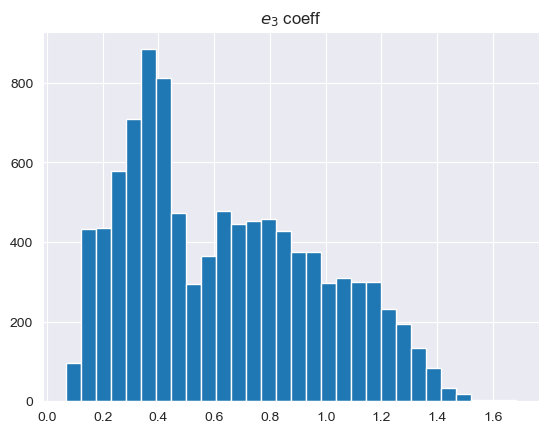

In [597]:
df["e_3_coeff"] = 10 * df["usage_rate"] * (1 - df["materials"])
plt.hist(df["e_3_coeff"], bins=30);
plt.title("$e_3$ coeff");

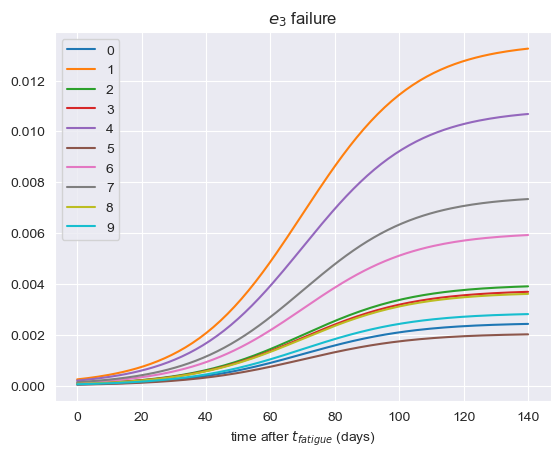

In [598]:
t = np.linspace(-10, 10, t_fatigue)
t_adjusted = (t + 10) * 7
e_3 = [y * e_3_coeff / 100 for e_3_coeff in df["e_3_coeff"]]

fig, ax = plt.subplots()
for idx, e_3_ in enumerate(e_3[:10]):
    ax.plot(t_adjusted, e_3_, label=idx)
ax.set(title="$e_3$ failure", xlabel="time after $t_{fatigue}$ (days)")
plt.legend();

In [471]:
df.head()

,operator_skills,brand,assembly_quality,model_id,ux,materials,usage_rate,e_1_lambda,e_2_coeff,e_3_coeff
0,1.0,B1,0.889414,Model 2,0.7,0.920184,0.309469,1.728335,0.559469,0.247007
1,0.5,B1,0.894534,Model 5,1.0,0.844707,0.869121,0.734152,1.988242,1.349688
2,1.0,B1,0.906668,Model 1,0.5,0.952254,0.832492,0.803749,1.082492,0.397478
3,0.5,B1,0.885838,Model 4,0.9,0.878855,0.309969,1.722511,0.869939,0.375511
4,1.0,B1,0.907561,Model 5,1.0,0.844338,0.698832,1.046656,0.948832,1.087817


## Sampling from all hazards

Total duration of the experiment: 2 years

$e_1$ during the $t_{init}=21$ first days (3 weeks)

In [609]:
def get_event_duration(y):
    event = any(y)
    duration = np.where(y == 1)[0]
    if duration.shape[0] > 0:
        duration = duration[0]
    else:
        duration = np.nan
    return event, duration

**Sampling $e_1$**

In [686]:
from scipy.stats import bernoulli

event_1, duration_1 = [], []

for e_1_ in e_1:
    y_1 = bernoulli.rvs(e_1_, random_state=rng)
    event, duration = get_event_duration(y_1)
    event_1.append(event)
    duration_1.append(duration)

event_1 = np.array(event_1)
duration_1 = np.array(duration_1)
    
np.unique(event_1, return_counts=True)

(array([False,  True]), array([9347,  653]))

$e_2$ between the $t_{init}=21$ first days and the $t_{fatigue}=130$ last days.

In [687]:
e_2_duration = total_period - t_init - t_fatigue
e_2_duration

579

**Sampling $e_2$**

In [688]:
event_2, duration_2 = [], []

for e_2_ in e_2:
    y_2 = bernoulli.rvs(e_2_, size=e_2_duration, random_state=rng)
    event, duration = get_event_duration(y_2)
    event_2.append(event)
    duration_2.append(duration)

event_2 = np.array(event_2)
duration_2 = np.array(duration_2) + t_init
    
np.unique(event_2, return_counts=True)

(array([False,  True]), array([4904, 5096]))

**Sampling $e_3$**

In [689]:
event_3, duration_3 = [], []

for e_3_ in e_3:
    y_3 = bernoulli.rvs(e_3_, random_state=rng)
    event, duration = get_event_duration(y_3)
    event_3.append(event)
    duration_3.append(duration)

event_3 = np.array(event_3)
duration_3 = np.array(duration_3) + 2 * 365 - t_fatigue

np.unique(event_3, return_counts=True)

(array([False,  True]), array([6730, 3270]))

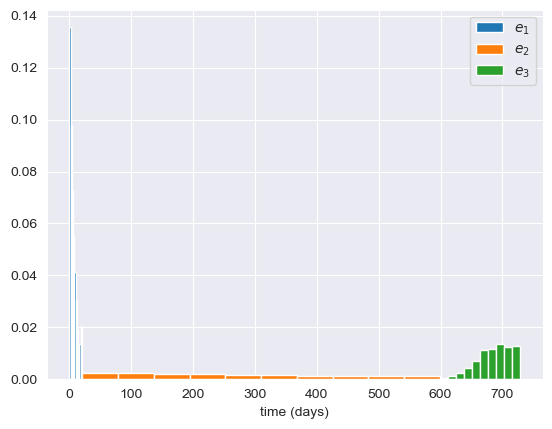

In [690]:
fig, ax = plt.subplots()
ax.hist(duration_1, label="$e_1$", density=True)
ax.hist(duration_2, label="$e_2$", density=True)
ax.hist(duration_3, label="$e_3$", density=True)
ax.set_xlabel("time (days)")
plt.legend();

In [691]:
any_event = np.logical_or(
    np.logical_or(
        event_1,
        event_2,
    ),
    event_3,
)
np.unique(any_event, return_counts=True)

(array([False,  True]), array([3129, 6871]))

We fetch the first hit.

In [692]:
stacked_durations = np.vstack([duration_1, duration_2, duration_3])
stacked_durations

array([[ nan,  nan,  nan, ...,  nan,  nan,   1.],
       [ nan, 155.,  nan, ...,  93., 120.,  nan],
       [ nan, 644.,  nan, ...,  nan, 661., 687.]])

In [738]:
duration_event = stacked_durations[:, any_event]
first_hit = np.nanargmin(duration_event, axis=0)
first_hit

array([1, 1, 2, ..., 1, 1, 0])

In [743]:
n_total = any_event.shape[0]
n_events = duration_event.shape[1]

duration = np.full(n_total, total_period)
jdxs = np.arange(n_events)
duration[any_event] = duration_event[first_hit, jdxs]
duration

array([730, 155, 730, ...,  93, 120,   1])

In [ ]:
first_hit += 1

In [757]:
event = any_event.astype(int).copy()
print(event.shape)
event

(10000,)


array([0, 1, 0, ..., 1, 1, 1])

In [756]:
print(first_hit.shape)
first_hit

(6871,)


array([2, 2, 3, ..., 2, 2, 1])

In [758]:
event[np.where(event)] = first_hit
print(event.shape)
event

(10000,)


array([0, 2, 0, ..., 2, 2, 1])

In [759]:
df["duration"] = duration
df["event"] = event
df

,operator_skills,brand,assembly_quality,model_id,ux,materials,usage_rate,e_1_lambda,e_2_coeff,e_3_coeff,duration,event
0,1.0,B1,0.889414,Model 2,0.7,0.920184,0.309469,1.728335,0.692099,0.247007,730,0
1,0.5,B1,0.894534,Model 5,1.0,0.844707,0.869121,0.734152,1.988242,1.349688,155,2
2,1.0,B1,0.906668,Model 1,0.5,0.952254,0.832492,0.803749,1.914983,0.397478,730,0
3,0.5,B1,0.885838,Model 4,0.9,0.878855,0.309969,1.722511,0.938821,0.375511,78,2
4,1.0,B1,0.907561,Model 5,1.0,0.844338,0.698832,1.046656,0.948832,1.087817,665,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,B2,0.760021,Model 3,0.8,0.893754,0.335716,1.509740,0.669645,0.356685,730,0
9996,1.0,B2,0.851973,Model 5,1.0,0.846817,0.788002,0.861233,1.038002,1.207083,691,3
9997,0.5,B2,0.861896,Model 2,0.7,0.916420,0.328632,1.657298,1.188949,0.274671,93,2
9998,0.8,B2,0.764227,Model 4,0.9,0.885173,0.853716,0.723588,1.435717,0.980296,120,2


In [760]:
observed_variables_and_target = [
    "operator_skills",
    "brand",
    "model_id",
    "usage_rate",
    "duration",
    "event",
]
df[observed_variables_and_target]

,operator_skills,brand,model_id,usage_rate,duration,event
0,1.0,B1,Model 2,0.309469,730,0
1,0.5,B1,Model 5,0.869121,155,2
2,1.0,B1,Model 1,0.832492,730,0
3,0.5,B1,Model 4,0.309969,78,2
4,1.0,B1,Model 5,0.698832,665,3
...,...,...,...,...,...,...
9995,1.0,B2,Model 3,0.335716,730,0
9996,1.0,B2,Model 5,0.788002,691,3
9997,0.5,B2,Model 2,0.328632,93,2
9998,0.8,B2,Model 4,0.853716,120,2


In [763]:
df[observed_variables_and_target].to_parquet("factory_dataset.parquet", index=False)

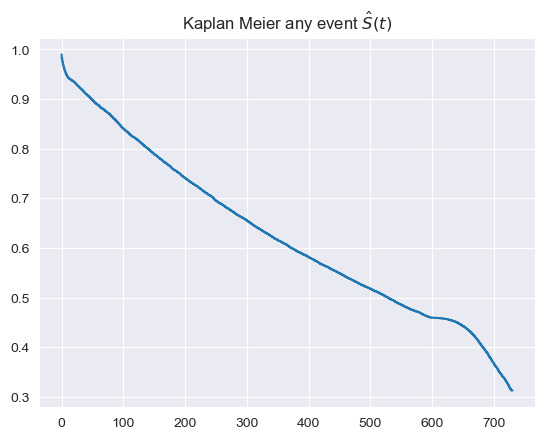

In [780]:
from sksurv.nonparametric import kaplan_meier_estimator

km_x, km_y = kaplan_meier_estimator(any_event, df["duration"])
plt.step(km_x, km_y)
plt.title("Kaplan Meier any event $\hat{S}(t)$");

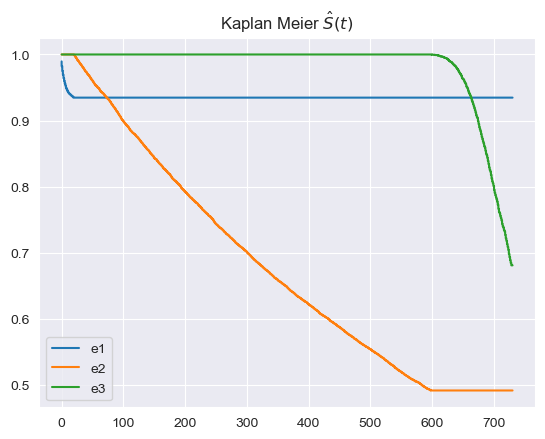

In [778]:
fig, ax = plt.subplots()
for event in [1, 2, 3]:
    km_x_, km_y_ = kaplan_meier_estimator(df["event"] == event, df["duration"])
    ax.step(km_x_, km_y_, label=f"e{event}")
plt.title("Kaplan Meier $\hat{S}(t)$");
plt.legend();

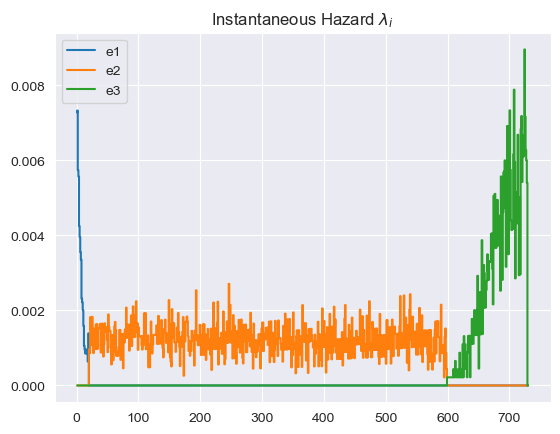

In [777]:
from sksurv.nonparametric import nelson_aalen_estimator

fig, ax = plt.subplots()
for event in [1, 2, 3]:
    na_x_, na_y_ = nelson_aalen_estimator(df["event"] == event, df["duration"])
    dt = na_x_[1:]
    dy = np.diff(na_y_)
    ax.step(dt, dy, label=f"e{event}")
plt.title("Instantaneous Hazard $\lambda_i$");
plt.legend();

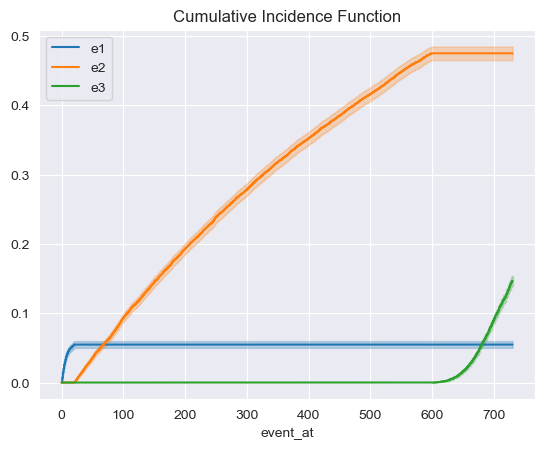

In [795]:
from lifelines import AalenJohansenFitter

for event in [1, 2, 3]:
    ajf = AalenJohansenFitter(calculate_variance=True)
    ajf.fit(df["duration"], df["event"], event_of_interest=event)
    ajf.plot(label=f"e{event}")
plt.title("Cumulative Incidence Function");

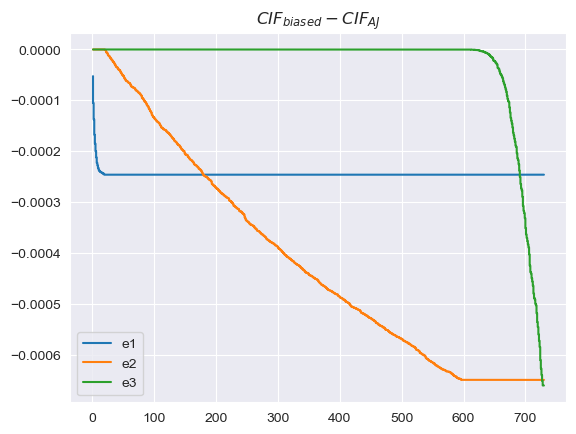

In [812]:
from sksurv.nonparametric import nelson_aalen_estimator

fig, ax = plt.subplots()
for event in [1, 2, 3]:
    ajf = AalenJohansenFitter(calculate_variance=True)
    ajf.fit(df["duration"], df["event"], event_of_interest=event)
    cif = ajf.cumulative_density_.values.ravel()[1:]
    
    na_x_, na_y_ = nelson_aalen_estimator(df["event"] == event, df["duration"])
    #_, km_y_ = kaplan_meier_estimator(df["event"] == event, df["duration"])
    _, km_y_ = kaplan_meier_estimator(any_event, df["duration"])
    dy = np.diff(na_y_) * km_y_[1:]
    cif_biased = np.cumsum(dy)
    t = na_x_[1:]
    
    ax.step(t, cif_biased - cif, label=f"e{event}")

plt.title("$CIF_{biased} - CIF_{AJ}$");
plt.legend();

(723,)